In [1]:
%matplotlib inline
import numpy as np
from scipy.misc import imread
import pickle
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize
import tensorflow as tf
from keras.preprocessing import image
from keras.backend.tensorflow_backend import set_session
from ssd import SSD300
from keras.applications.imagenet_utils import preprocess_input
from ssd_utils import BBoxUtility
import matplotlib.pyplot as plt
from SSD_tester import calc_detection_prec_rec, calc_detection_ap
from SSD_RGBD import RGBD_SSD300
from depth_preprocess import hole_filling
import cv2

config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
        visible_device_list="0",
        allow_growth=True 
    )
)
sess = sess = tf.Session(config=config)



Using TensorFlow backend.


In [2]:
NYU_CLASSES = ['bathtub', 'bed', 'bookshelf', 'box', 'chair', 'counter', 'desk', 'door', 'dresser',
               'garbage_bin', 'lamp', 'monitor', 'night_stand', 'pillow', 'sink', 'sofa', 'table', 'tv', 'toilet']
NUM_CLASSES = len(NYU_CLASSES) + 1
rgb_input_shape = (300, 300, 3) #channel lastde
depth_input_shape = (300, 300, 1)

In [3]:
model = RGBD_SSD300(rgb_input_shape, depth_input_shape, num_classes=NUM_CLASSES)
model.load_weights('/data/jun/checkpoints/SUNRGBD/estimation/RGBD-1/v1/weights-5.49-2.30.hdf5',by_name=True)

In [4]:
rgb_gt = pickle.load(open('../pkls/SUNRGBD/RGB_v8.pkl', 'rb'))
depth_gt = pickle.load(open('../pkls/SUNRGBD/Depth_v8.pkl', 'rb'))
rgb_keys = pickle.load(open('/data/jun/pkls/RGBD-1/rgb-v1.pkl', 'rb'))
depth_keys = pickle.load(open('/data/jun/pkls/RGBD-1/depth-v1.pkl', 'rb'))
num_train = int(round(0.8 * len(rgb_keys)))
rgb_train_keys = rgb_keys[:num_train]
depth_train_keys = depth_keys[:num_train]
num_val = int(round((len(rgb_keys) - num_train)/2))
rgb_val_keys = rgb_keys[num_train:]
rgb_val_keys = rgb_val_keys[:num_val]
depth_val_keys = depth_keys[num_train:]
depth_val_keys = depth_val_keys[:num_val]
rgb_test_keys = rgb_keys[num_train:]
rgb_test_keys = rgb_test_keys[num_val:]
depth_test_keys = depth_keys[num_train:]
depth_test_keys = depth_test_keys[num_val:]
print(depth_keys[0])

SUNRGBD/xtion/sun3ddata/home_han/apartment_han_oct_31_2012_scan1_erika/0002876-000119853216//depth/0002876-000119840697.png


In [5]:
path_prefix = '/data/jun/dataset/'
rgb_inputs = []
depth_inputs = []
images = []
# img_path = path_prefix + sorted(val_keys )[100]
# img = image.load_img(img_path, target_size=(300, 300))
# img = image.img_to_array(img)
# images.append(imread(img_path))
# inputs.append(img.copy())
# inputs = preprocess_input(np.array(inputs))

for rgb_key, depth_key in zip(rgb_test_keys, depth_test_keys):
    rgb_img_path = path_prefix + rgb_key
    depth_img_path = path_prefix + depth_key
    rgb_img = imread(rgb_img_path).astype('float32')
    depth_img = imread(depth_img_path, mode='L').astype('float32')
    rgb_img = imresize(rgb_img, (300, 300)).astype('float32')
    depth_img = imresize(depth_img, (300, 300)).astype('float32')
    depth_img = depth_img / np.max(depth_img)
    depth_img = np.sqrt(depth_img)
    depth_img = np.array(depth_img*256, dtype=int)
    depth_img = hole_filling(depth_img)
    depth_img = np.uint8(depth_img)
    depth_img = cv2.Canny(depth_img, 70, 110)
    depth_img = cv2.bilateralFilter(depth_img, d=5, sigmaColor=5, sigmaSpace=2)
    depth_img = np.expand_dims(depth_img, axis=2)
    std = np.std(rgb_img)
    rgb_img -= np.mean(rgb_img)
    rgb_img /= std
    img = imread(rgb_img_path)
    images.append(img)

    
    rgb_inputs.append(rgb_img.copy())
    depth_inputs.append(depth_img.copy())
    
inputs = [np.array(rgb_inputs), np.array(depth_inputs)]

/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()
/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transfo

In [6]:
inputs[0].shape



(966, 300, 300, 3)

In [7]:
priors = pickle.load(open('../pkls/prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)
preds = model.predict(inputs, batch_size=16, verbose=1)

966/966 [==============================] - 24s    


In [8]:
results = bbox_util.detection_out(preds, confidence_threshold=0.5)

In [9]:
gt_bboxes = []
gt_labels = []
gt_scores = []
for key in rgb_test_keys:
    index = np.where(rgb_gt[key][:, 4:] == 1)
    gt_bboxes.append(rgb_gt[key][:, :4])
    gt_labels.append((index[1]).reshape(len(index[1]), 1))
    gt_scores.append(np.ones((len(index[1]), 1)))
gt_bboxes = np.array(gt_bboxes)
gt_labels = np.array(gt_labels)
gt_scores = np.array(gt_scores)

In [10]:
pred_labels = []
pred_scores = []
pred_bboxes = []
for result in results:
    if len(result) != 0:
        nm = len(result[:, 1])
        pred_labels.append((result[:, 0]-1).reshape(nm, 1))
        pred_scores.append(result[:, 1:2].reshape(nm, 1))
        pred_bboxes.append(result[:, 2:].reshape(nm, 4))
    else:
        pred_labels.append(np.array([]).reshape(0, 1))
        pred_scores.append(np.array([]).reshape(0, 1))
        pred_bboxes.append(np.array([]).reshape(0, 1))
pred_labels = np.array(pred_labels)
pred_scores = np.array(pred_scores)

pred_bboxes = np.array(pred_bboxes)

In [11]:
gt_labels.shape

(966,)

In [16]:
prec, rec, mean_iou = calc_detection_prec_rec(pred_labels, pred_scores, pred_bboxes, gt_bboxes, gt_labels, iou_thresh=0.5)

In [17]:
ap = calc_detection_ap(prec, rec, use_07_metric=True)
{'ap': ap, 'map': np.nanmean(ap)}

{'ap': array([ 0.35227273,  0.69018511,  0.45690943,  0.08717949,  0.50446367,
         0.51133467,  0.38825903,  0.39395171,  0.1801006 ,  0.45865801,
         0.39716534,  0.32153406,  0.5523765 ,  0.43792839,  0.51724657,
         0.51485887,  0.45400655,  0.36742424,  0.72727273]),
 'map': 0.43753303555186929}

In [20]:
import csv

f_recall = open('rgbd-1_recall.csv', 'w')
f_precision = open('rgbd-1_precision.csv', 'w')
writer_recall = csv.writer(f_recall, lineterminator='\n')
writer_precision = csv.writer(f_precision, lineterminator='\n')

In [21]:
for i in range(len(NYU_CLASSES)):
#    plt.figure()
    y = prec[i]
    x = rec[i]
    writer_recall.writerow(x)
    writer_precision.writerow(y)
f_recall.close()
f_precision.close()

#     plt.plot(x, y)
#     plt.axis([0, 1.0, 0, 1.0])
#     plt.title(NYU_CLASSES[i])
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.savefig(('../results/PRC/RGBD-1/' + NYU_CLASSES[i]+'.png'))

In [15]:
mAP_array = []
for i in np.linspace(0, 1, 101):
    prec, rec, mean_iou = calc_detection_prec_rec(pred_labels, pred_scores, pred_bboxes, gt_bboxes, gt_labels, iou_thresh=i)
    ap = calc_detection_ap(prec, rec, use_07_metric=True)
    mAP_array.append(np.nanmean(ap))

[0.45483324404668535, 0.45483324404668535, 0.45483324404668535, 0.45483324404668535, 0.45483324404668535, 0.45483292536462655, 0.45483292536462655, 0.45483292536462655, 0.45483292536462655, 0.45483292536462655, 0.45483292536462655, 0.4547500736071336, 0.4547500736071336, 0.4547500736071336, 0.4547500736071336, 0.4547500736071336, 0.45137625444384072, 0.45118711885899004, 0.44797169800115794, 0.44797169800115794, 0.4479587739151274, 0.4479587739151274, 0.4479587739151274, 0.4479587739151274, 0.4479587739151274, 0.44492418252650212, 0.44489747373625776, 0.44488288626980893, 0.44488288626980893, 0.44371418687139935, 0.44331980144163441, 0.44249664250440313, 0.44248925952962198, 0.44247060513895026, 0.44211579446237925, 0.44211579446237925, 0.44211579446237925, 0.44207679446686565, 0.44207623142979868, 0.44033005425886368, 0.44032809010081964, 0.44016865397829968, 0.44008099307315124, 0.44007501307582575, 0.43888030914788606, 0.43870065136344105, 0.43860291045578453, 0.43794571269026433, 0

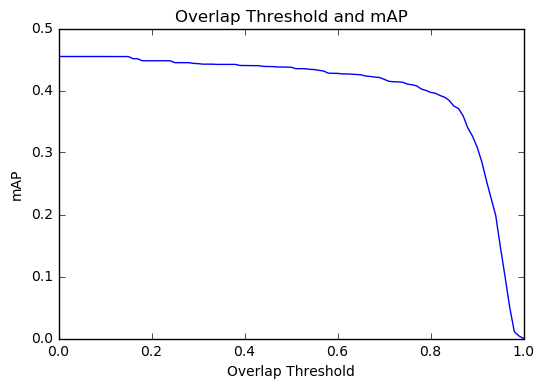

In [ ]:
print(mAP_array)
plt.plot(np.linspace(0, 1, 101), np.array(mAP_array))
plt.title('Overlap Threshold and mAP')
plt.xlabel('Overlap Threshold')
plt.ylabel('mAP')
plt.savefig('../results/map_overlap/RGBD-1.png')

In [22]:
ap_array = np.zeros((len(NYU_CLASSES), len(np.linspace(0, 1, 101))))
for i, thresh in enumerate(np.linspace(0, 1, 101)):
    prec, rec, mean_iou = calc_detection_prec_rec(pred_labels, pred_scores, pred_bboxes, gt_bboxes, gt_labels, iou_thresh=thresh)
    ap = calc_detection_ap(prec, rec, use_07_metric=True)
    for k in range(len(NYU_CLASSES)):
        ap_array[k][i] = ap[k]

        

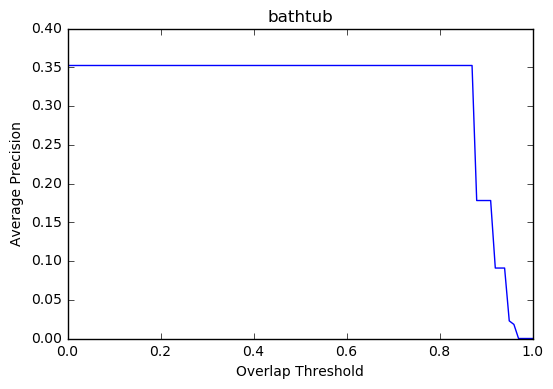

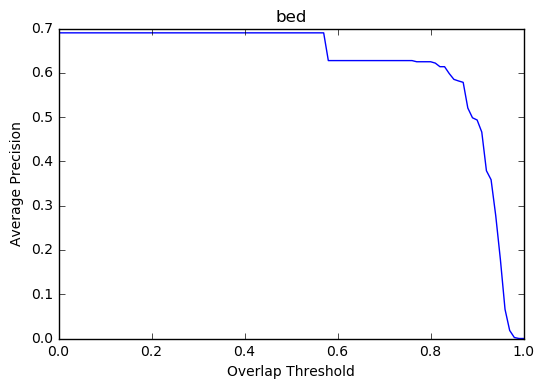

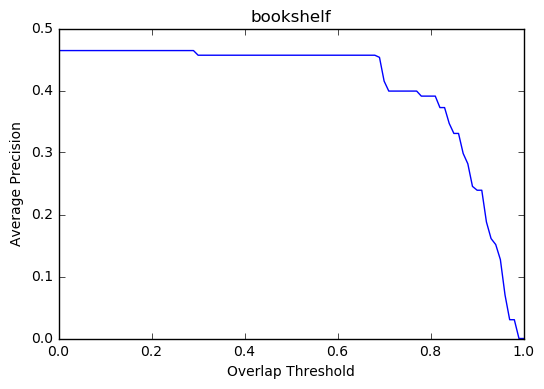

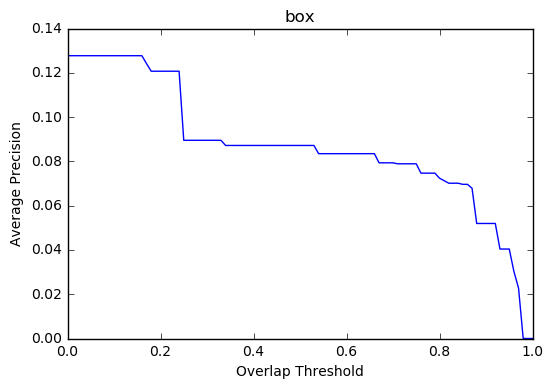

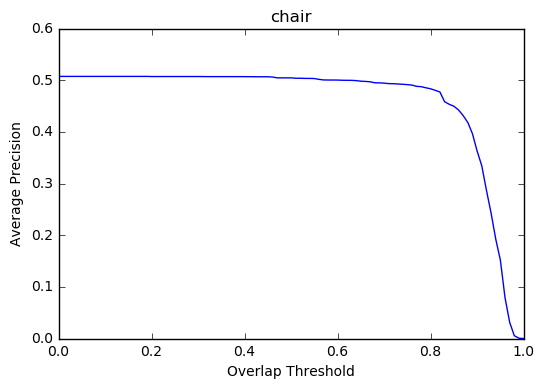

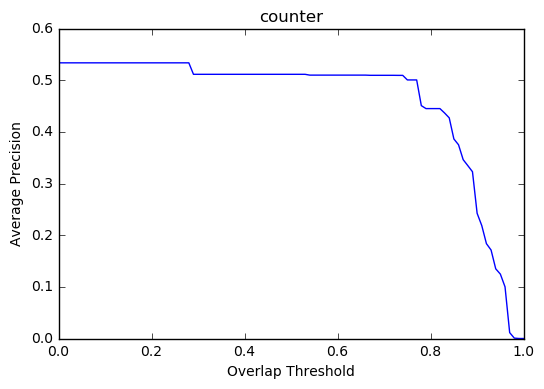

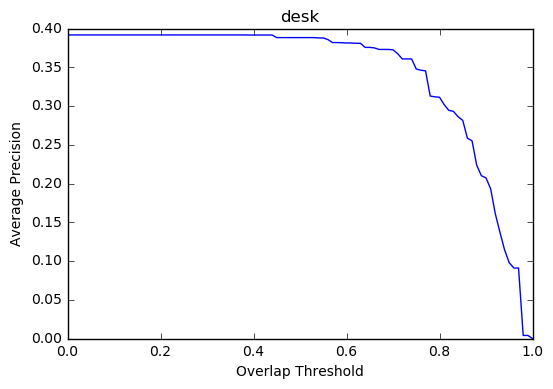

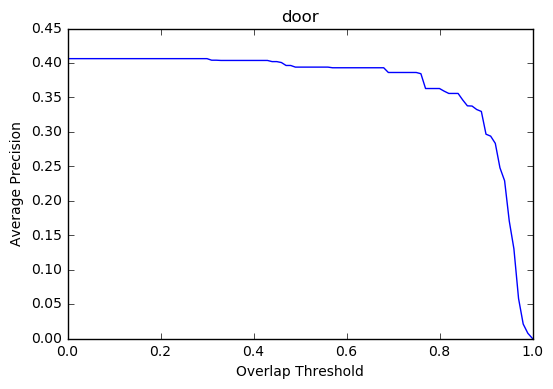

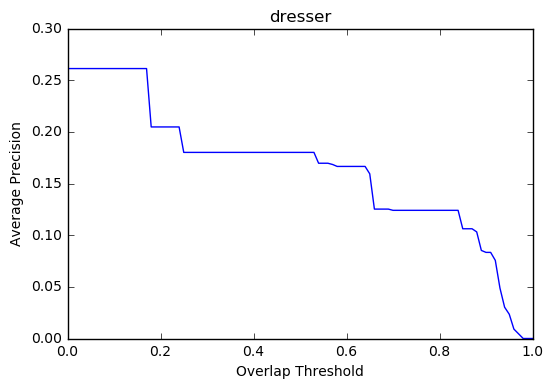

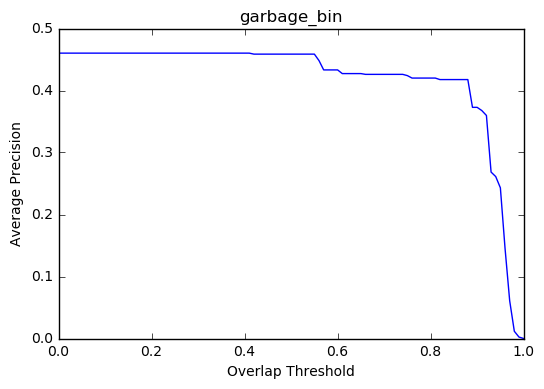

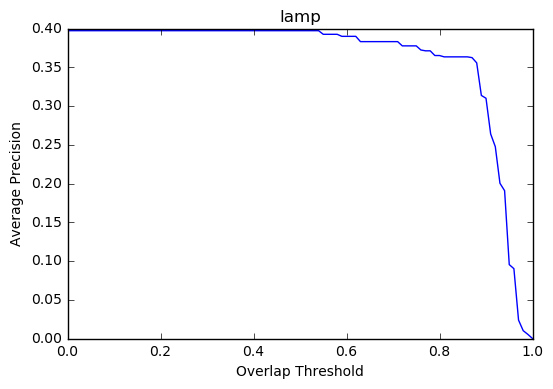

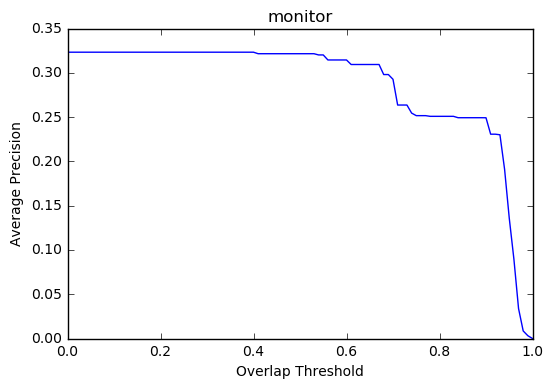

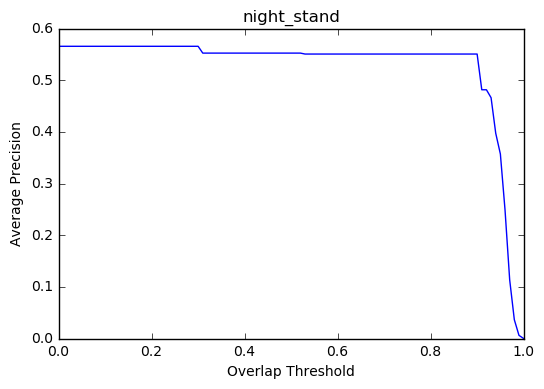

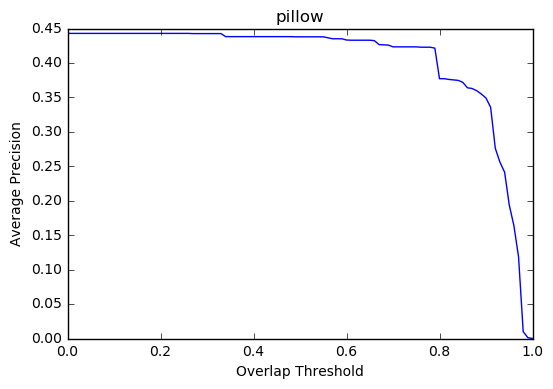

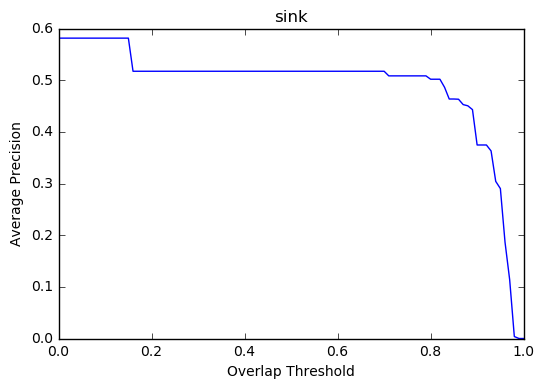

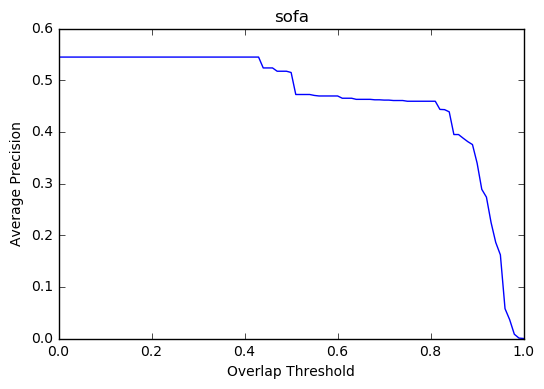

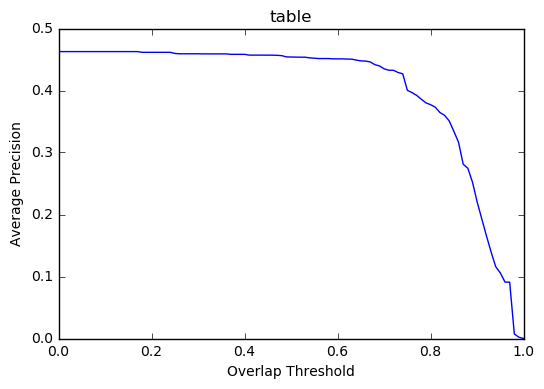

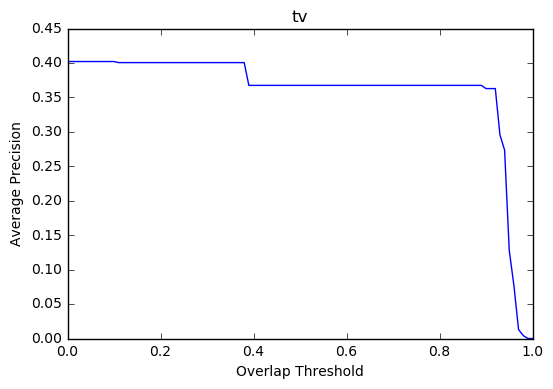

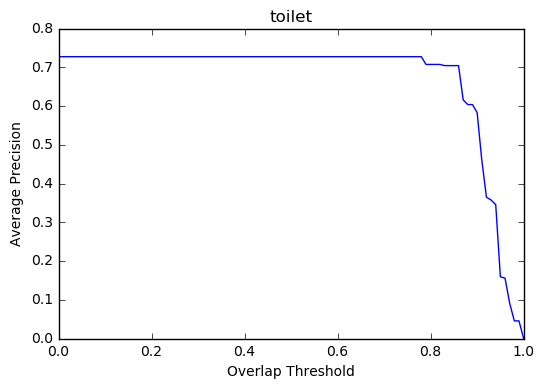

In [23]:

for k in range(len(NYU_CLASSES)):
    plt.figure()
    plt.plot(np.linspace(0, 1, 101), np.array(ap_array[k]))
    plt.title(NYU_CLASSES[k])
    plt.xlabel('Overlap Threshold')
    plt.ylabel('Average Precision')
    plt.savefig(('../results/ap_overlap/RGBD-1/'+NYU_CLASSES[k]+'.png'))

In [ ]:
for i, img in enumerate(images):
    plt.figure()
    if len(results[i]) == 0:
        continue
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    plt.imshow(img / 255.)
    currentAxis = plt.gca()


    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = NYU_CLASSES[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin, ymax-ymin
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.savefig('../results/detection_images/RGBD-1/image' + str(i) + '_v1.png')

/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [ ]:
#calc_map()
y_true = []
for key in val_keys:
    y_true.append(gt[key])
y_true = np.array(y_true)
print(y_true.shape)

In [ ]:
inputs = []
images = []
for key in val_keys:
    img_path = path_prefix + key
    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

In [ ]:
#calc_map(y_true, results)
print(results[0])